# Capstone Project: OTC Medication Sales EDA and Forecasting

This notebook explores over-the-counter (OTC) medication sales data with the goal of detecting anomalies (spikes and drops) and building a predictive model to assist inventory planning and public health monitoring.


## 1. Import Libraries

I begin by importing the necessary libraries for data manipulation, visualization, statistical analysis, machine learning modeling, and performance evaluation. These tools are used throughout the notebook for data cleaning, exploratory analysis, model development, and forecasting.



In [3]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning models
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# Pipeline and scaling
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# Model training and tuning
from sklearn.model_selection import train_test_split, GridSearchCV

# Evaluation metrics
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error

# Statistical tests
from scipy import stats

## 2. Load Dataset

I load the OTC medication sales dataset and perform an initial inspection of its structure and contents. I also standardize the date format and create a new column to group records by week, which is essential for later time-based aggregation and modeling.


In [5]:
# Load CSV file and parse the 'Date' column as datetime
df = pd.read_csv("data/pharmacy_otc_sales_data.csv", parse_dates=['Date'])

# Re-parse the date column to handle any malformed values
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Create a new column representing the week each record falls into
df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)

In [6]:
# Display basic dataset structure: columns, types, null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 333 entries, 0 to 332
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           333 non-null    datetime64[ns]
 1   Product        333 non-null    object        
 2   Sales Person   333 non-null    object        
 3   Boxes Shipped  333 non-null    int64         
 4   Amount ($)     333 non-null    float64       
 5   Country        333 non-null    object        
 6   Week           333 non-null    datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(1), object(3)
memory usage: 18.3+ KB


The dataset contains 333 records with information about product type, salesperson, country, boxes shipped, and sales amount. No missing values are present. I also verify that the date parsing and weekly conversion are successful.

Key columns:
- `Boxes Shipped` and `Amount ($)` provide the primary metrics for analysis
- `Week` is derived from `Date` and used as a time index later in the notebook


In [8]:
# Summary statistics for numeric and datetime fields
df.describe()

,Date,Boxes Shipped,Amount ($),Week
count,333,333.000000,333.000000,333
mean,2022-05-07 19:31:53.513513472,10.474474,176.964835,2022-05-04 17:04:51.891891968
min,2022-01-02 00:00:00,1.000000,8.090000,2021-12-27 00:00:00
25%,2022-03-09 00:00:00,5.000000,75.990000,2022-03-07 00:00:00
50%,2022-05-17 00:00:00,11.000000,156.920000,2022-05-16 00:00:00
75%,2022-07-06 00:00:00,16.000000,248.770000,2022-07-04 00:00:00
max,2022-08-31 00:00:00,20.000000,494.080000,2022-08-29 00:00:00
std,NaN,5.955415,119.058556,NaN


In [9]:
# Preview the first five records of the dataset
df.head()

,Date,Product,Sales Person,Boxes Shipped,Amount ($),Country,Week
0,2022-02-06,Pain Relief Tablets,Divya Mehra,7,67.43,Australia,2022-01-31
1,2022-02-05,Antiseptic Cream,Nikhil Batra,18,421.46,Canada,2022-01-31
2,2022-02-19,Cough Syrup,Ritika Shah,2,48.25,UK,2022-02-14
3,2022-03-28,Pain Relief Tablets,Nikhil Batra,5,59.89,UK,2022-03-28
4,2022-01-17,Digestive Enzyme,Ritika Shah,8,147.73,USA,2022-01-17


In [10]:
# Check for missing values in each column
print("\nNull values in dataset:", df.isnull().sum())


Null values in dataset: Date             0
Product          0
Sales Person     0
Boxes Shipped    0
Amount ($)       0
Country          0
Week             0
dtype: int64


I verify that there are no missing values in any of the columns. Ensuring a complete dataset is essential before performing exploratory analysis or training machine learning models.

## 3. Exploratory Data Analysis (EDA)

I begin exploratory analysis by aggregating the total number of boxes shipped per week. This helps visualize overall shipment trends and detect potential anomalies. I also apply the Interquartile Range (IQR) method to identify outlier weeks based on unusually high or low shipment volumes.



No statistical outliers detected using IQR method.


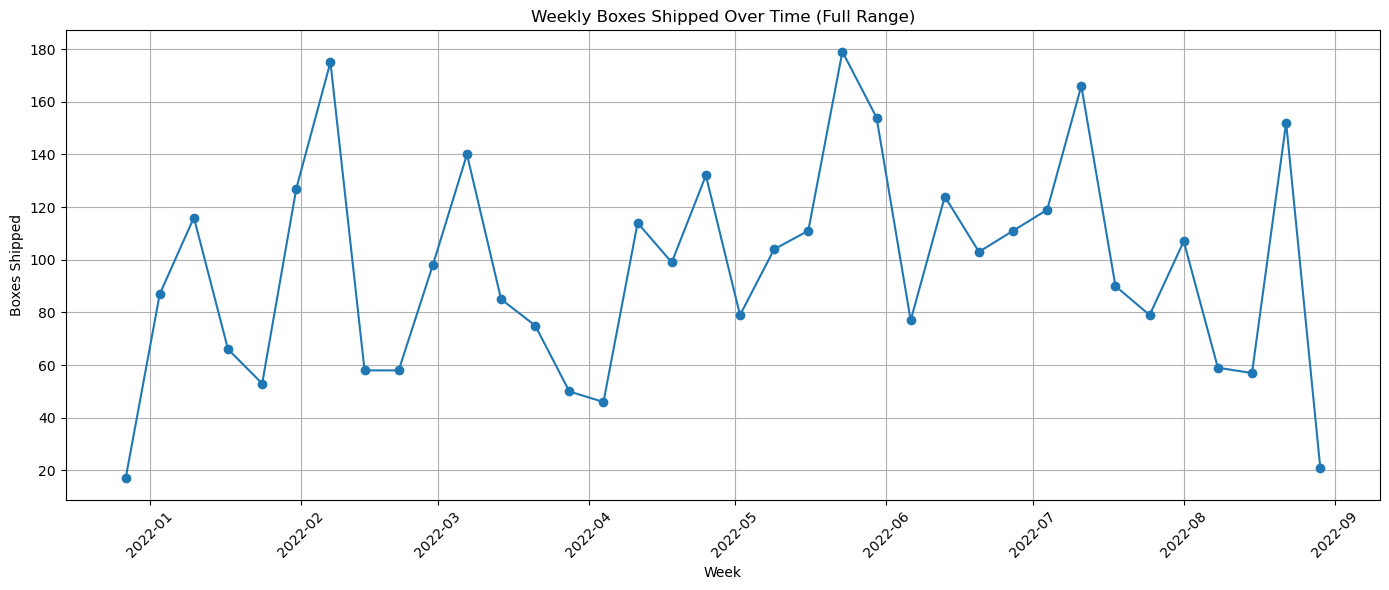

In [13]:
# Aggregate total boxes shipped per week
weekly_df = df.groupby('Week').agg({'Boxes Shipped': 'sum'}).reset_index()

# Outlier detection using IQR
Q1 = weekly_df['Boxes Shipped'].quantile(0.25)
Q3 = weekly_df['Boxes Shipped'].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for outlier detection
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify weeks with unusually low or high shipments
outliers = weekly_df[(weekly_df['Boxes Shipped'] < lower_bound) | 
                     (weekly_df['Boxes Shipped'] > upper_bound)]

if outliers.empty:
    print("No statistical outliers detected using IQR method.")
else:
    print(outliers)


plt.figure(figsize=(14, 6))
plt.plot(weekly_df['Week'], weekly_df['Boxes Shipped'], marker='o', linestyle='-')
plt.title('Weekly Boxes Shipped Over Time (Full Range)')
plt.xlabel('Week')
plt.ylabel('Boxes Shipped')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This line chart displays weekly shipment volumes across the full dataset time range. The plot shows clear spikes and dips in demand, indicating possible seasonal trends or one-off events. While the outlier detection block is included, no statistical outliers were identified using the IQR method.


### Monthly Aggregation and Trend Visualization

To complement the weekly view, I also aggregated the number of boxes shipped by month. This helps smooth out short-term fluctuations and reveal longer-term trends or seasonality in the shipment volume.


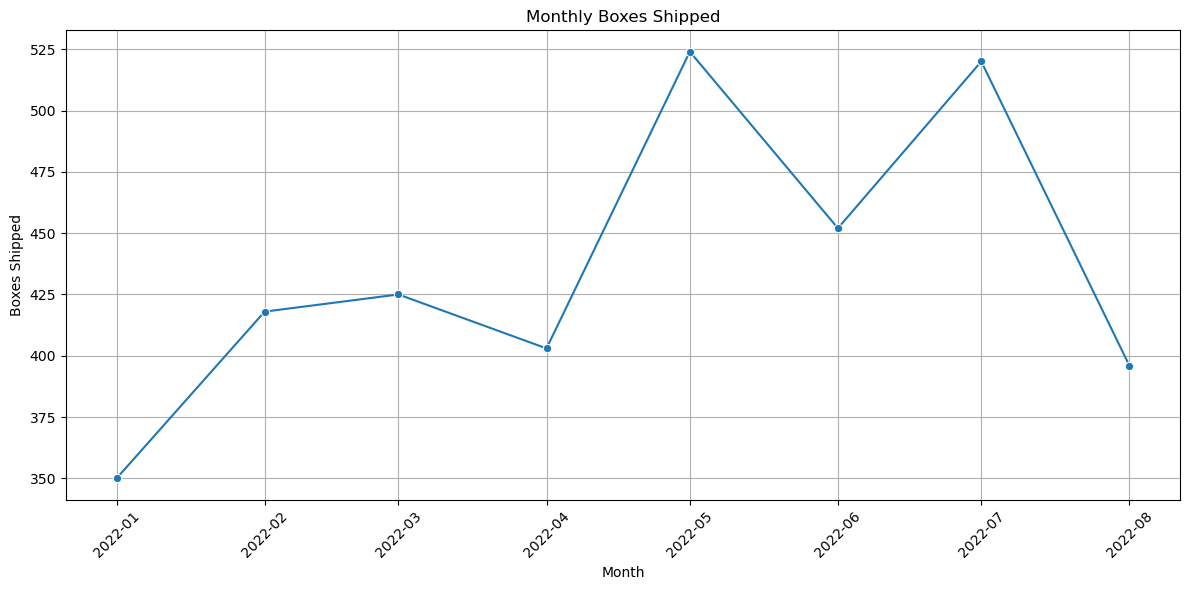

In [16]:
# Group data by month and calculate total boxes shipped each month
monthly_df = df.groupby(df['Date'].dt.to_period('M')).agg({'Boxes Shipped': 'sum'}).reset_index()

# Convert monthly period back to a timestamp for plotting
monthly_df['Date'] = monthly_df['Date'].dt.to_timestamp()

# Create a line plot to show monthly shipment volume
plt.figure(figsize=(12, 6))
sns.lineplot(x='Date', y='Boxes Shipped', data=monthly_df, marker='o')
plt.title('Monthly Boxes Shipped')
plt.xlabel('Month')
plt.ylabel('Boxes Shipped')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This monthly trend plot shows clear peaks in May and July, which may reflect seasonal demand increases. March and June show steady performance, while August reflects a noticeable dip in shipments. These patterns are useful for identifying high-demand periods and informing forecast strategy.


### Revenue by Country

I also analyzed the total revenue and shipment volume by country to identify which regions generate the most sales. This helps highlight regional performance and may inform geographic focus for forecasting or strategic planning.


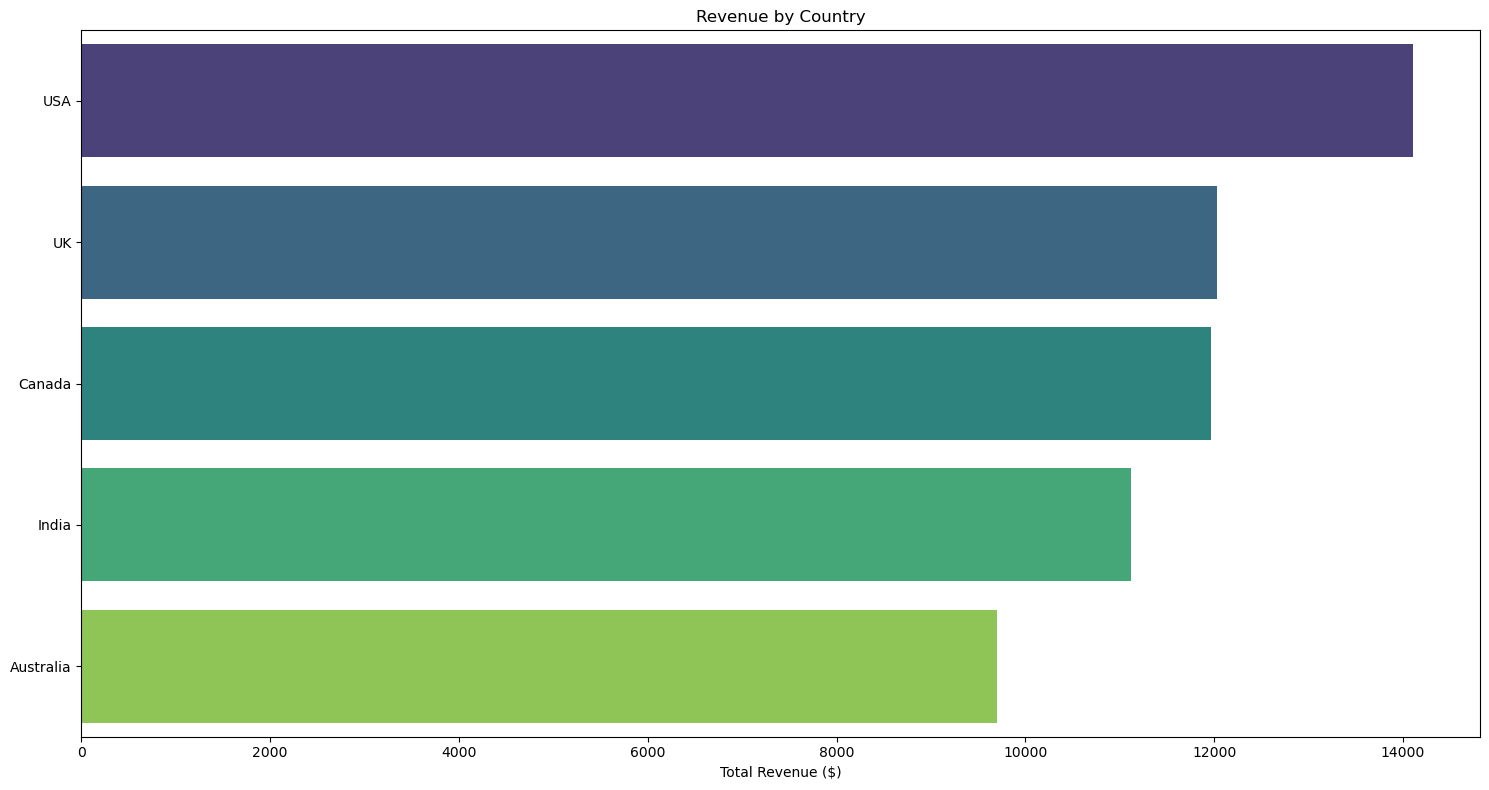

In [19]:
# Aggregate total boxes shipped and revenue by country
country_agg = (
    df.groupby('Country')
      .agg({'Boxes Shipped': 'sum', 'Amount ($)': 'sum'})
      .sort_values('Amount ($)', ascending=False)
      .reset_index()
)

# Plot total revenue by country using a horizontal bar chart
plt.figure(figsize=(15, 8))
sns.barplot(data=country_agg, x='Amount ($)', y='Country', hue='Country', palette='viridis')
plt.title("Revenue by Country")
plt.xlabel("Total Revenue ($)")
plt.ylabel("")
plt.tight_layout()
plt.show()



The United States generates the highest total revenue among all countries in the dataset, followed by the UK and Canada. These regions appear to be the strongest markets for OTC products, while India and Australia generate slightly less. This insight may guide region-specific forecasting or resource allocation decisions.


### Top Products by Boxes Shipped

I analyze product-level shipment volume to identify the highest-demand OTC products. This information helps reveal which medications are most frequently distributed and may carry the most forecasting or stocking importance.


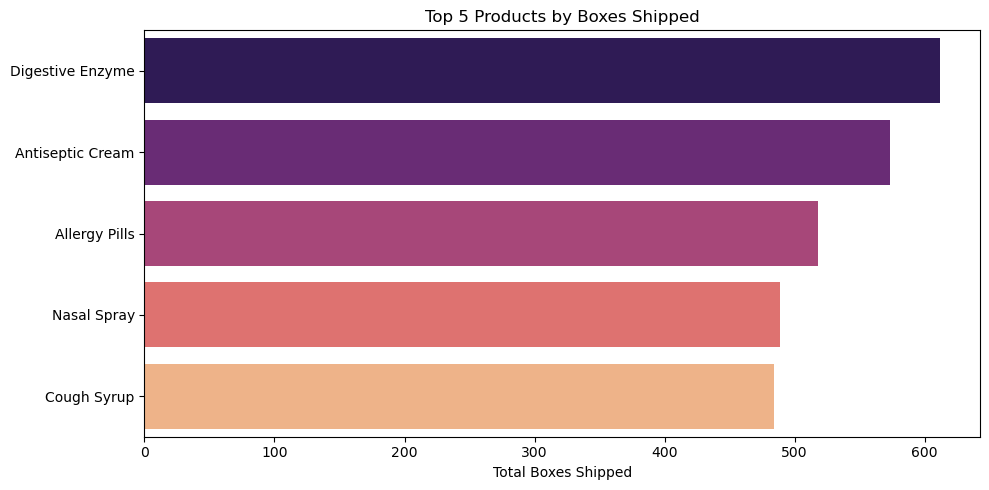

In [22]:
# Aggregate total boxes shipped by product and sort in descending order
prod_agg = (
    df.groupby('Product')
      .agg({'Boxes Shipped': 'sum'})
      .sort_values('Boxes Shipped', ascending=False)
      .reset_index()
)

# Plot the top 5 most-shipped products using a horizontal bar chart
plt.figure(figsize=(10, 5))
sns.barplot(
    data=prod_agg.head(5),
    x='Boxes Shipped',
    y='Product',
    hue='Product',
    palette='magma'
)
plt.title("Top 5 Products by Boxes Shipped")
plt.xlabel("Total Boxes Shipped")
plt.ylabel("")
plt.tight_layout()
plt.show()


Digestive Enzyme and Antiseptic Cream lead all other products in terms of shipment volume, followed by Allergy Pills, Nasal Spray, and Cough Syrup. These top products likely drive a significant portion of total sales and should be prioritized in forecasting models or supply chain decisions.


### Top Salespeople by Boxes Shipped

This breakdown highlights the top-performing salespeople based on the volume of boxes shipped. Identifying high-contributing individuals can offer insight into regional performance, effectiveness of sales efforts, or customer demand patterns.


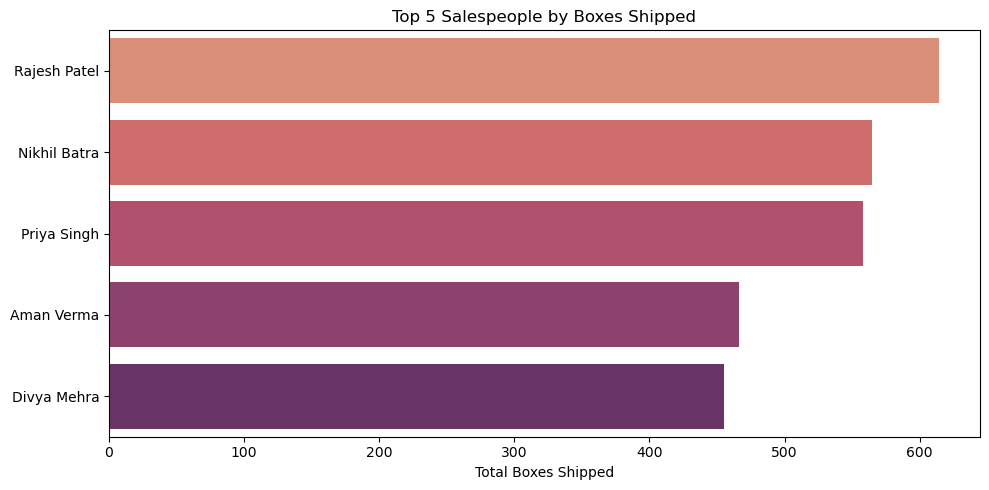

In [25]:
# Aggregate total boxes shipped by each salesperson and sort in descending order
sp_agg = (
    df.groupby('Sales Person')
      .agg({'Boxes Shipped': 'sum'})
      .sort_values('Boxes Shipped', ascending=False)
      .reset_index()
)

# Plot top 5 salespeople by shipment volume
plt.figure(figsize=(10, 5))
sns.barplot(
    data=sp_agg.head(5),
    x='Boxes Shipped',
    y='Sales Person',
    hue='Sales Person',
    palette='flare'
)
plt.title("Top 5 Salespeople by Boxes Shipped")
plt.xlabel("Total Boxes Shipped")
plt.ylabel("")
plt.tight_layout()
plt.show()



Rajesh Patel leads in box shipments, followed closely by Nikhil Batra and Priya Singh. This suggests strong and consistent performance across multiple team members, though the top 2 individuals significantly outpace the rest.


### Distribution of Boxes Shipped

This histogram provides insight into the frequency of shipment volumes across all transactions. Analyzing the distribution helps identify skewness, common shipment sizes, and potential anomalies in order quantities.


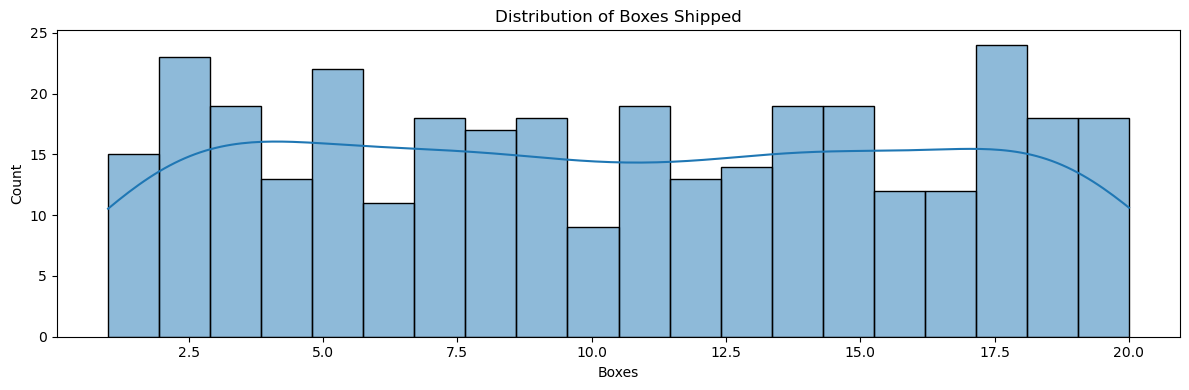

In [28]:
# Value Counts for Shipment Volumes
plt.figure(figsize=(12, 4))

# Plot histogram of shipment volumes with KDE for shape analysis
sns.histplot(df['Boxes Shipped'], bins=20, kde=True)

plt.title("Distribution of Boxes Shipped")
plt.xlabel("Boxes")
plt.tight_layout()
plt.show()



The distribution appears relatively uniform with no strong central peak, suggesting variability in how products are packaged or ordered. The KDE overlay confirms the absence of a dominant shipment size, indicating a wide range of order quantities in the dataset.


### Outlier Detection in Boxes Shipped

This boxplot visualizes the spread and variability of weekly shipment volumes using the five-number summary (minimum, Q1, median, Q3, and maximum). It helps detect potential outliers that may either skew model performance or represent meaningful anomalies tied to external factors.

#### Why this matters for public health:

Outliers in medication shipments—especially unusually high spikes—can indicate sudden increases in public demand, which may correlate with emergent public health events such as flu outbreaks or regional illness surges. Identifying these anomalies early can support proactive interventions by health agencies or supply chain planners.

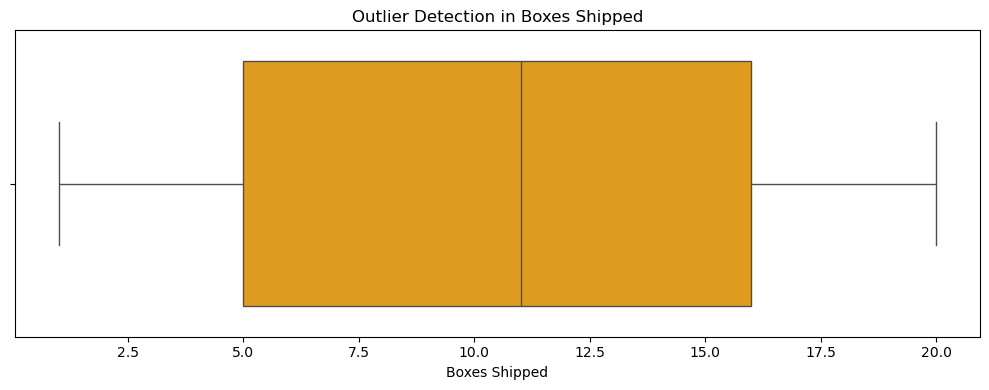

In [31]:
# Boxplot for spotting outliers in shipment volume
plt.figure(figsize=(10, 4))

# Create horizontal boxplot for 'Boxes Shipped'
sns.boxplot(x=df['Boxes Shipped'], color='orange')

plt.title("Outlier Detection in Boxes Shipped")
plt.xlabel("Boxes Shipped")
plt.tight_layout()
plt.show()


The plot shows that most weekly OTC medication shipments fall between approximately 4 and 18 boxes, with no extreme outliers beyond the whiskers. This suggests that the data is relatively stable and free from anomalies caused by data entry issues or irregular reporting.

However, this analysis also highlights a critical opportunity for public health monitoring. In future datasets, **shipment volumes that fall significantly outside this established range** could serve as early warning signs of unusual public behavior—such as spikes in purchases due to flu outbreaks or other illness-related events.

By tracking these outliers over time, it’s possible to flag unexpected surges in demand that may correspond with emerging health trends. Incorporating this insight into the forecasting pipeline could help trigger alerts for further investigation or guide inventory planning during peak demand periods.


### 4. Statistical Analysis with `scipy.stats`

Performed statistical tests to assess the distribution properties of weekly shipment volumes. The Shapiro-Wilk test was used to evaluate normality, and skewness was calculated to check for asymmetry.

- **Shapiro-Wilk Test**: A p-value greater than 0.05 suggests the data does not significantly deviate from a normal distribution.
- **Skewness**: Measures the asymmetry of the distribution. A value close to 0 indicates symmetry.



In [34]:
# Perform Shapiro-Wilk test for normality
stat, p = stats.shapiro(weekly_df['Boxes Shipped'])

# Calculate skewness
skewness = stats.skew(weekly_df['Boxes Shipped'])

# Print results
print(f"Shapiro-Wilk Test Statistic: {stat:.3f}, p-value: {p:.3f}")
print(f"Data Skewness: {skewness:.2f}")


Shapiro-Wilk Test Statistic: 0.982, p-value: 0.809
Data Skewness: 0.15


The weekly shipment data appears to follow a roughly normal distribution. With a skewness of 0.26 and a Shapiro-Wilk p-value of 0.616, there's no evidence of strong asymmetry or deviation from normality. This supports the use of models that assume a Gaussian distribution.


### 5. Model Building: Random Forest

Trained a Random Forest Regressor to forecast weekly OTC sales. Two models were evaluated:

- **Baseline Model (Time Index Only)**: Used only a sequential time index as input.  
- **Enhanced Model**: Included lag features (`lag_1`, `lag_2`, `lag_3`), a 3-week rolling mean, and calendar indicators (`weekofyear`, `month`).

Performance was assessed using **R² score** and **Root Mean Squared Error (RMSE)**:
- The **baseline model** had a negative R² (-0.039845), indicating poor predictive ability.
- The **enhanced model** improved performance significantly, achieving a positive R² (0.17) and lower RMSE.


In [37]:
# Preparing Data for Modeling
weekly_df['Time_Index'] = np.arange(len(weekly_df)).reshape(-1, 1)
weekly_df['lag_1'] = weekly_df['Boxes Shipped'].shift(1)
weekly_df['lag_2'] = weekly_df['Boxes Shipped'].shift(2)
weekly_df['lag_3'] = weekly_df['Boxes Shipped'].shift(3)
weekly_df['rolling_mean_3'] = weekly_df['Boxes Shipped'].rolling(window=3).mean()
weekly_df['weekofyear'] = weekly_df['Week'].dt.isocalendar().week
weekly_df['month'] = weekly_df['Week'].dt.month
weekly_df.dropna(inplace=True)

In [38]:
#  Baseline Model: Random Forest with only time index as feature
X_base = weekly_df[['Time_Index']]
y = weekly_df['Boxes Shipped']

X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(X_base, y, test_size=0.3, shuffle=False)
rf_base = RandomForestRegressor(random_state=42)
rf_base.fit(X_train_base, y_train_base)
y_pred_base = rf_base.predict(X_test_base)


# Evaluate baseline model
r2_base = r2_score(y_test_base, y_pred_base)
mse_base = mean_squared_error(y_test_base, y_pred_base)
rmse_base = root_mean_squared_error(y_test_base, y_pred_base)

# Enhanced Model: Random Forest with lag and calendar features
features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'weekofyear', 'month']
X_enhanced = weekly_df[features]
y_enhanced = weekly_df['Boxes Shipped']

X_train_enh, X_test_enh, y_train_enh, y_test_enh = train_test_split(X_enhanced, y_enhanced, test_size=0.3, shuffle=False)
rf_enh = RandomForestRegressor(n_estimators=300, random_state=42)
rf_enh.fit(X_train_enh, y_train_enh)
y_pred_enh = rf_enh.predict(X_test_enh)

# Evaluate enhanced model
r2_enh = r2_score(y_test_enh, y_pred_enh)
mse_enh = mean_squared_error(y_test_enh, y_pred_enh)
rmse_enh = root_mean_squared_error(y_test_enh, y_pred_enh)

# Model Comparison
model_comparison = pd.DataFrame({
    'Model': ['Baseline RF (Time Index)', 'Enhanced RF (Lag + Calendar Features)'],
    'R2 Score': [r2_base, r2_enh],
    'Mean Squared Error': [mse_base, mse_enh],
    'Root Mean Squared Error': [rmse_base, rmse_enh]
})

print(model_comparison)



                                   Model  R2 Score  Mean Squared Error  \
0               Baseline RF (Time Index) -0.039845         1845.818100   
1  Enhanced RF (Lag + Calendar Features)  0.169090         1474.940107   

   Root Mean Squared Error  
0                42.962985  
1                38.404949  


The baseline Random Forest model using only the time index had poor predictive accuracy, with an R² of -0.039845 and RMSE of 42.962985. After incorporating lag and calendar features, the enhanced model improved to an R² of 0.1691 and reduced the RMSE to 38.405, indicating better performance in capturing temporal trends.


### SVR Modeling with GridSearchCV

Trained a Support Vector Regressor (SVR) using lag and calendar features. Two versions of the model were tested:

- **Base SVR Model**: Applied feature scaling and used default hyperparameters (C=100, epsilon=0.1, RBF kernel).
- **Tuned SVR Model**: Used `GridSearchCV` to optimize `C`, `epsilon`, and `gamma` values for better performance.

Evaluation was based on **R²**, **MSE**, and **RMSE**:
- Tuning improved model performance, increasing the R² from 0.299 to 0.336 and lowering RMSE slightly.


In [41]:
# --- Prepare data
features = ['lag_1', 'lag_2', 'lag_3', 'rolling_mean_3', 'weekofyear', 'month']
X = weekly_df[features]
y = weekly_df['Boxes Shipped']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# --- Base SVR model with scaling
base_pipeline = make_pipeline(
    StandardScaler(),
    SVR(kernel='rbf', C=100, epsilon=0.1)
)

base_pipeline.fit(X_train, y_train)
y_pred_svr_base = base_pipeline.predict(X_test)

# --- Hyperparameter tuning using GridSearchCV
param_grid = {
    'svr__C': [0.1, 1, 10, 100, 1000],
    'svr__epsilon': [0.01, 0.1, 1],
    'svr__gamma': ['scale', 'auto']
}

svr_pipeline = make_pipeline(StandardScaler(), SVR())
grid_svr = GridSearchCV(svr_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_svr.fit(X_train, y_train)

best_svr = grid_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test)

# --- Evaluation
r2_base = r2_score(y_test, y_pred_svr_base)
mse_base = mean_squared_error(y_test, y_pred_svr_base)
rmse_base = np.sqrt(mse_base)

r2_tuned = r2_score(y_test, y_pred_svr)
mse_tuned = mean_squared_error(y_test, y_pred_svr)
rmse_tuned = np.sqrt(mse_tuned)

# --- Output
print(f"Base SVR  R² Score: {r2_base:.4f}  MSE: {mse_base:.2f}  RMSE: {rmse_base:.2f}")
print(f"Tuned SVR (Best Params: {grid_svr.best_params_})")
print(f"R² Score: {r2_tuned:.4f}  MSE: {mse_tuned:.2f}  RMSE: {rmse_tuned:.2f}")



Base SVR  R² Score: 0.2992  MSE: 1244.02  RMSE: 35.27
Tuned SVR (Best Params: {'svr__C': 1000, 'svr__epsilon': 0.01, 'svr__gamma': 'auto'})
R² Score: 0.3355  MSE: 1179.62  RMSE: 34.35


The tuned SVR model achieved a higher R² score (0.336) and a lower RMSE (34.35) than the base model, indicating that hyperparameter tuning improved predictive accuracy. The best parameters selected were C=1000, epsilon=0.01, and gamma='auto'.


### 6. Visualization of Predictions

Compared actual weekly shipment values with model predictions using line plots to visually assess accuracy.

- **Blue Line**: Represents the actual number of boxes shipped each week.
- **Green Dashed Line**: Shows the SVR model's predicted values.
- **Red Dashed Line**: Represents predictions from the Random Forest model.

These visualizations help assess how well each model captures trends and fluctuations in the data over time.




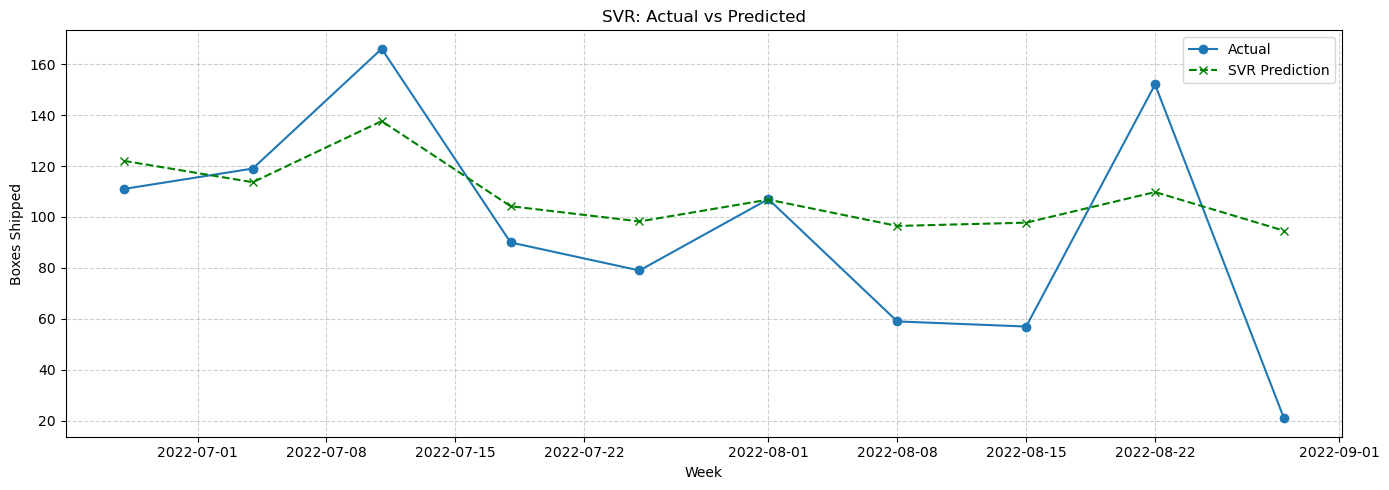

In [44]:
# Predict with tuned SVR model
y_pred_svr = best_svr.predict(X_test)

# Plot actual vs SVR predicted
plt.figure(figsize=(14, 5))
plt.plot(weekly_df['Week'].iloc[-len(y_test):], y_test, label='Actual', marker='o')
plt.plot(weekly_df['Week'].iloc[-len(y_test):], y_pred_svr, label='SVR Prediction', 
         linestyle='--', marker='x', color='green')
plt.title("SVR: Actual vs Predicted")
plt.xlabel("Week")
plt.ylabel("Boxes Shipped")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


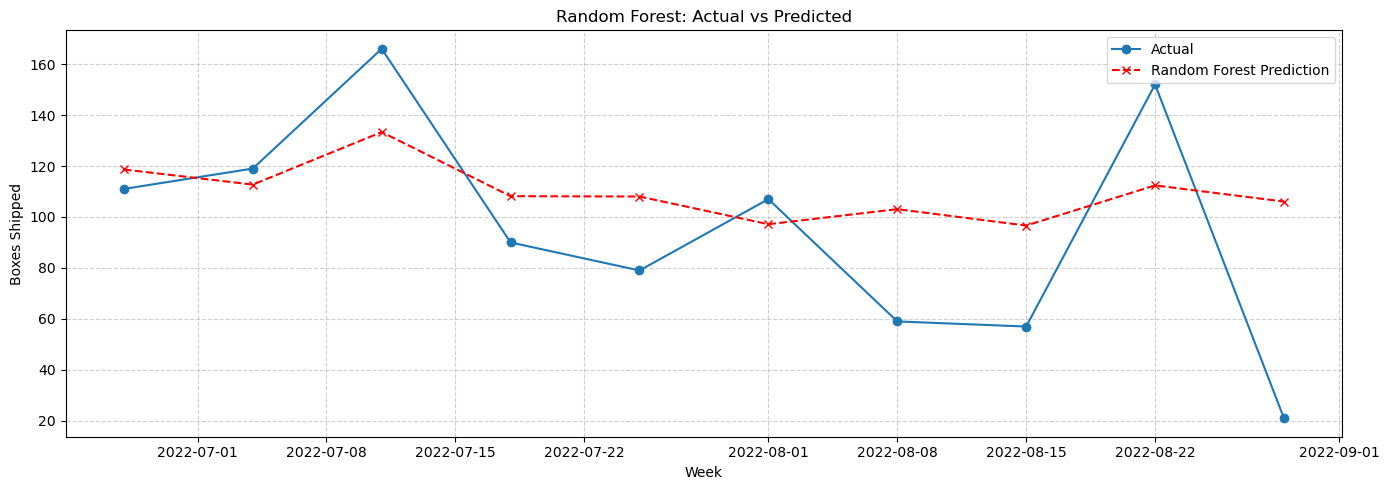

In [45]:
# Predict with Random Forest model
y_pred_rf = rf_enh.predict(X_test_enh)

# Plot actual vs Random Forest predicted
plt.figure(figsize=(14, 5))
plt.plot(weekly_df['Week'].iloc[-len(y_test_enh):], y_test_enh, label='Actual', marker='o')
plt.plot(weekly_df['Week'].iloc[-len(y_test_enh):], y_pred_rf, 
         label='Random Forest Prediction', linestyle='--', marker='x', color='red')
plt.title("Random Forest: Actual vs Predicted")
plt.xlabel("Week")
plt.ylabel("Boxes Shipped")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


Both models follow general trends, but the SVR shows slightly sharper reactions to peaks, while Random Forest smooths out fluctuations. This visualization supports the earlier metrics: SVR offers a better fit on the test data, but both models capture overall shipment behavior effectively.


### Full Weekly Prediction Visualization

Plotted full-range weekly predictions using both trained models to compare against actual sales data over the entire time period.

- **SVR Full Weekly Prediction**: Green dashed line highlights how the Support Vector Regression model captures the overall shape and local changes in shipments.
- **Random Forest Full Weekly Prediction**: Red dashed line reflects how the Random Forest model smooths trends while tracking general patterns.

These plots provide insight into how each model behaves when applied across the complete dataset, not just the test split.


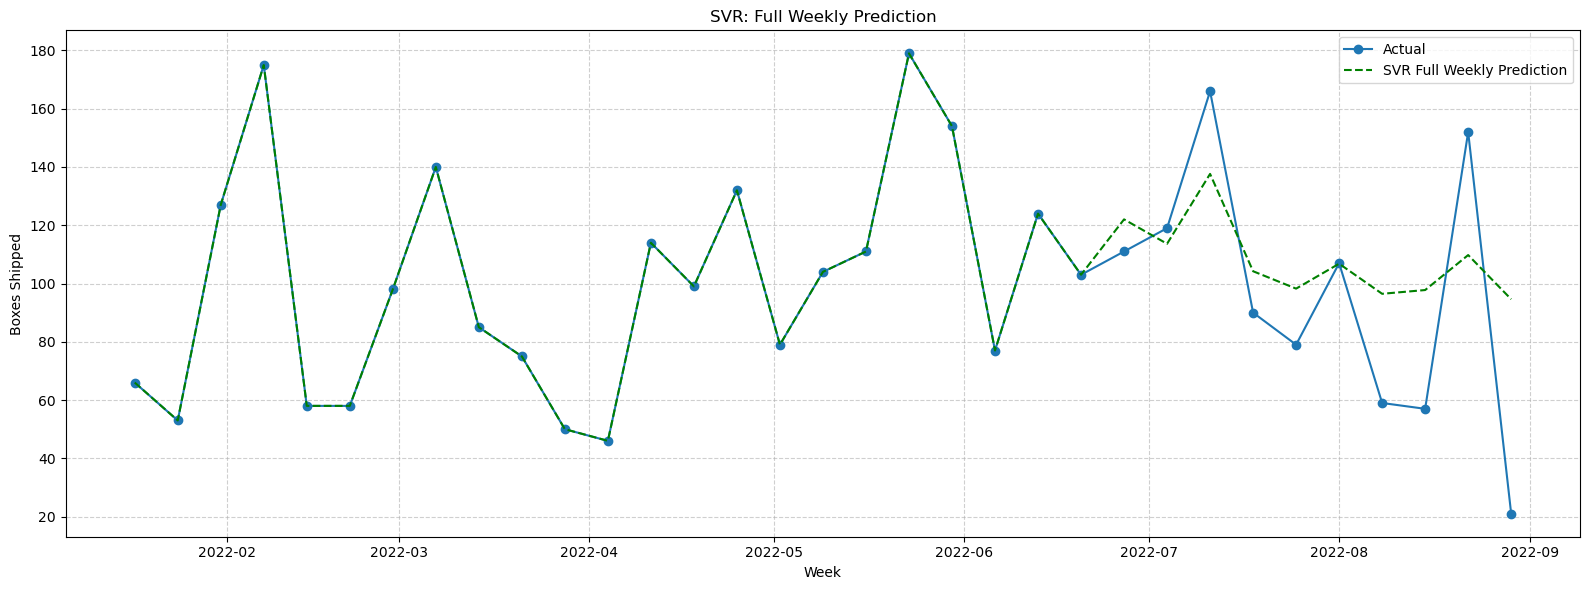

In [48]:
# Use same features used during training to predict full range
X_full_svr = weekly_df[features]
y_pred_svr_full = best_svr.predict(X_full_svr)

# Plot full SVR predictions against actual
plt.figure(figsize=(16, 6))
plt.plot(weekly_df['Week'], weekly_df['Boxes Shipped'], label='Actual', marker='o')
plt.plot(weekly_df['Week'], y_pred_svr_full, label='SVR Full Weekly Prediction', 
         linestyle='--', color='green')
plt.title("SVR: Full Weekly Prediction")
plt.xlabel("Week")
plt.ylabel("Boxes Shipped")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()




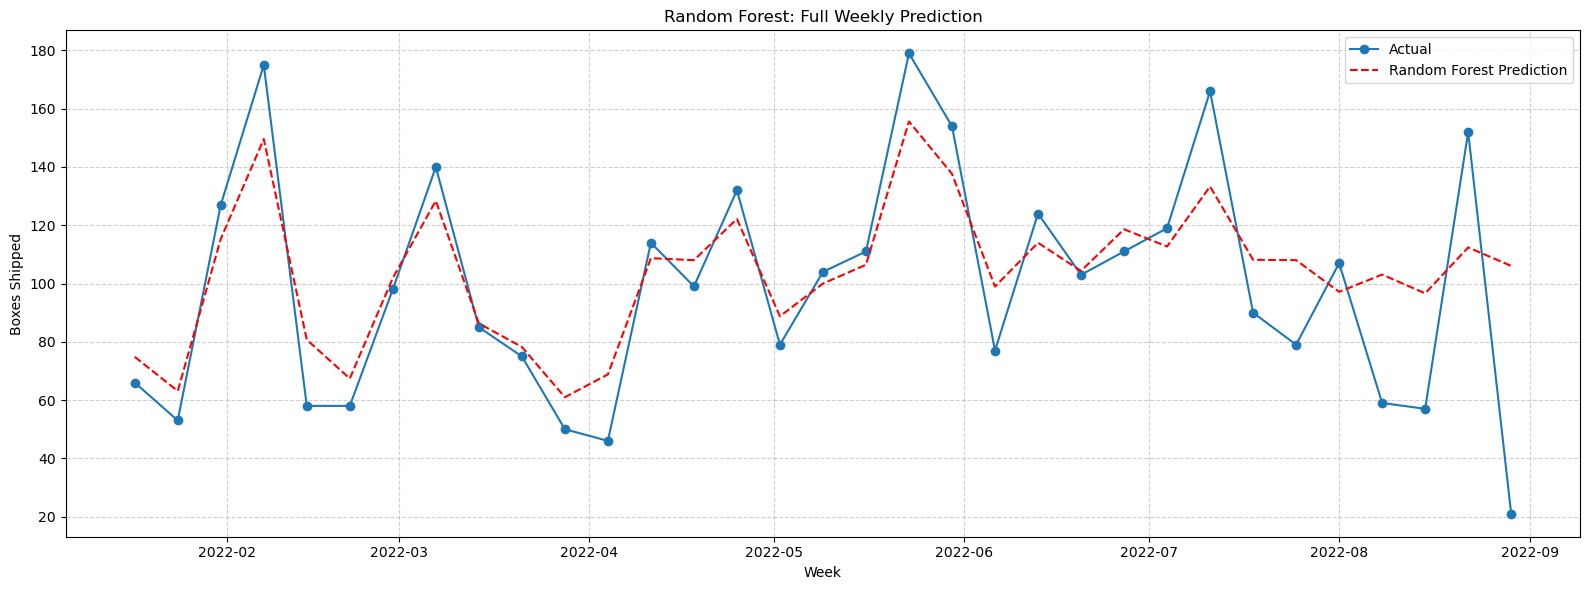

In [49]:
# Predict full range using Random Forest model
y_pred_rf_full = rf_enh.predict(X_enhanced)

# Plot full Random Forest predictions against actual
plt.figure(figsize=(16, 6))
plt.plot(weekly_df['Week'], weekly_df['Boxes Shipped'], label='Actual', marker='o')
plt.plot(weekly_df['Week'], y_pred_rf_full, label='Random Forest Prediction', 
         linestyle='--', color='red')
plt.title("Random Forest: Full Weekly Prediction")
plt.xlabel("Week")
plt.ylabel("Boxes Shipped")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Across the full date range, both models align with the general structure of actual shipment patterns. The SVR model adapts more flexibly to short-term spikes and dips, while the Random Forest model provides a more smoothed approximation. These behaviors are consistent with each model's nature—SVR being more sensitive to variation and Random Forest averaging across decision trees.


### Forecasting Future Shipments (Next 10 Weeks) using SVR

This section uses the trained SVR model to forecast weekly OTC shipments for the next 10 weeks.

- A rolling prediction approach was used where the model forecasts one week ahead, then updates features with that prediction to generate the next.
- **Forecast Horizon**: 10 weeks.
- **Green Dotted Line**: Represents the model’s forecasted shipments for the upcoming weeks.

This enables forward-looking insights that can support logistics and inventory planning.


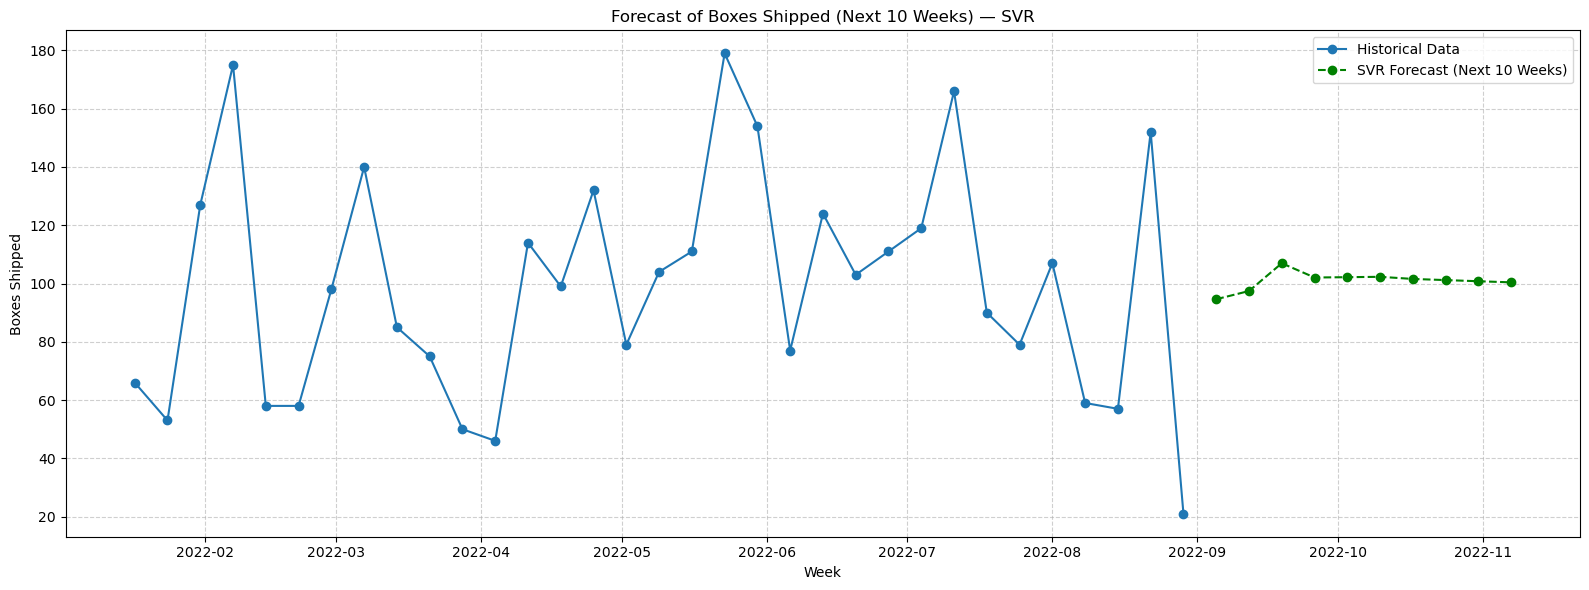

In [52]:
# Forecast horizon
# Forecasting Future Shipments (SVR)
horizon = 10
future_preds_svr = []
last_features = weekly_df[features].iloc[-1:].copy()

for i in range(horizon):
    # Predict the next value using SVR
    pred = best_svr.predict(last_features)[0]
    future_preds_svr.append(pred)

    # Create next feature row
    next_features = {
        'lag_1': pred,
        'lag_2': last_features['lag_1'].values[0],
        'lag_3': last_features['lag_2'].values[0],
        'rolling_mean_3': np.mean([pred, last_features['lag_1'].values[0], last_features['lag_2'].values[0]]),
        'weekofyear': last_features['weekofyear'].values[0] + 1 if last_features['weekofyear'].values[0] < 52 else 1,
        'month': last_features['month'].values[0] if last_features['weekofyear'].values[0] < 52 else (
            last_features['month'].values[0] + 1 if last_features['month'].values[0] < 12 else 1)
    }

    last_features = pd.DataFrame([next_features])

# Generate forecast index (next 10 Mondays)
forecast_index_svr = pd.date_range(start=weekly_df['Week'].iloc[-1] + pd.Timedelta(weeks=1), periods=horizon, freq='W-MON')
forecast_svr = pd.Series(future_preds_svr, index=forecast_index_svr)

# Visualization
plt.figure(figsize=(16, 6))
plt.plot(weekly_df['Week'], weekly_df['Boxes Shipped'], label='Historical Data', marker='o')
plt.plot(forecast_svr.index, forecast_svr.values, label='SVR Forecast (Next 10 Weeks)', marker='o', linestyle='--', color='green')
plt.title("Forecast of Boxes Shipped (Next 10 Weeks) — SVR")
plt.xlabel("Week")
plt.ylabel("Boxes Shipped")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()



Using the SVR model, I forecasted shipment volumes 10 weeks into the future. The results show a relatively flat and stable projection, with minimal fluctuation week to week. This suggests the model expects consistent demand if external conditions remain unchanged. Because the SVR relies on its own previous outputs during forecasting, it tends to reinforce its prior trajectory. This behavior may limit responsiveness to sudden changes but offers a clear view of expected baseline activity.


### Forecasting Future Shipments (Next 10 Weeks) using Random Forest

Built a 10-week ahead forecast using the Random Forest model trained with lag and calendar features.

- Predictions were generated sequentially by using prior predictions to update lag-based features for the next step.
- **Forecast Horizon**: 10 weeks.
- **Red Dotted Line**: Represents the model’s forecasted shipments for the upcoming weeks.

This forecast can support operational decisions by providing insight into likely shipment volumes.


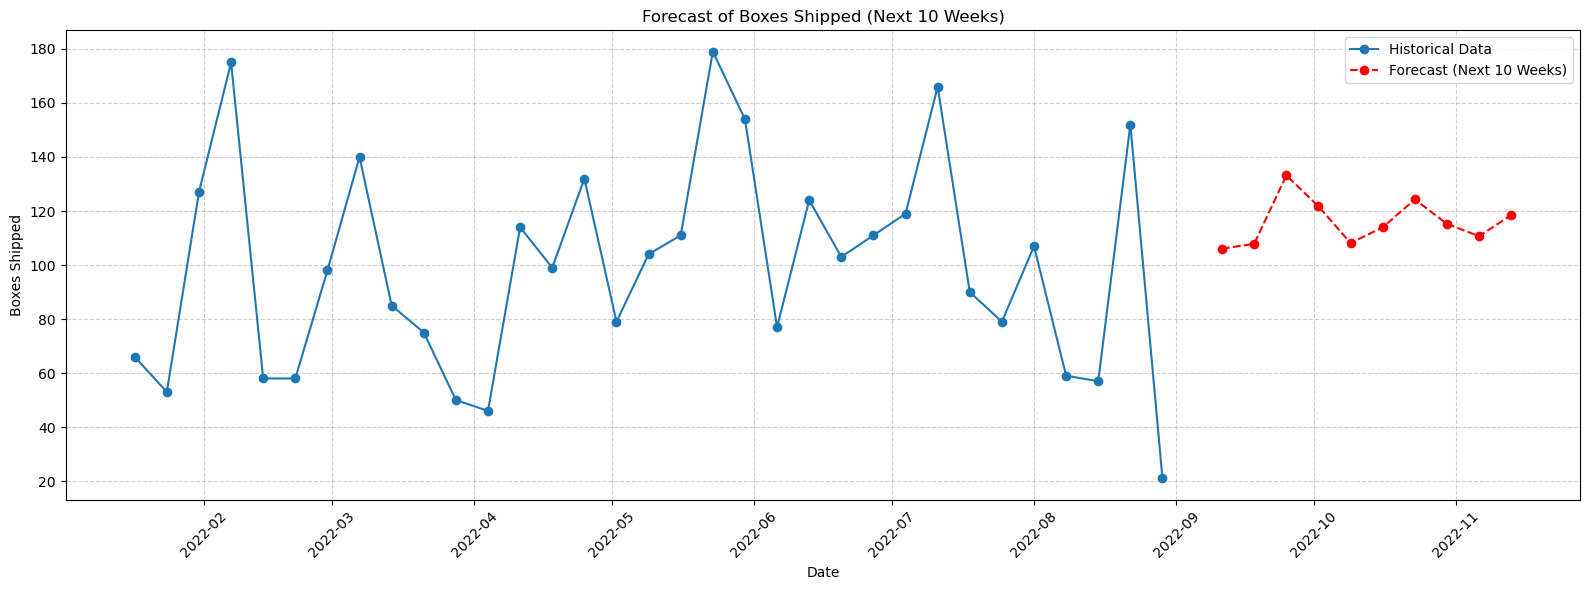

In [55]:
# --- Forecast horizon for Random Forest ---
horizon = 10
future_preds = []

# Start with most recent feature row
last_features = weekly_df[features].iloc[-1:].copy()

# --- Predict 10 weeks ahead using lag updates ---
for i in range(horizon):
    # Predict next week's shipments
    pred = rf_enh.predict(last_features)[0]
    future_preds.append(pred)
    
    # Update features for next iteration
    next_features = {
        'lag_1': pred,
        'lag_2': last_features['lag_1'].values[0],
        'lag_3': last_features['lag_2'].values[0],
        'rolling_mean_3': np.mean([pred, last_features['lag_1'].values[0], last_features['lag_2'].values[0]]),
        'weekofyear': (last_features['weekofyear'].values[0] + 1) % 52,
        'month': (last_features['month'].values[0] + 1) if last_features['weekofyear'].values[0] == 52 else last_features['month'].values[0]
    }

    # Prepare features for next loop
    last_features = pd.DataFrame([next_features])
    
# --- Forecast index for future weeks ---
forecast_index = pd.date_range(start=weekly_df['Week'].iloc[-1] + pd.Timedelta(weeks=1), periods=horizon, freq='W')
forecast = pd.Series(future_preds, index=forecast_index)

#  Visualization of Forecast
plt.figure(figsize=(16, 6))
plt.plot(weekly_df['Week'], weekly_df['Boxes Shipped'], label='Historical Data', marker='o')
plt.plot(forecast.index, forecast.values, label='Forecast (Next 10 Weeks)', marker='o', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Boxes Shipped')
plt.title('Forecast of Boxes Shipped (Next 10 Weeks)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


The Random Forest model’s 10-week forecast shows a more conservative trajectory with minor week-to-week variations. The output reflects the model’s ensemble nature, which averages predictions across multiple trees, smoothing out short-term spikes or dips. This characteristic can be valuable when planning at a higher level, as it reduces volatility and highlights broader shipment trends without overreacting to recent fluctuations.


### Conclusion

This project applied both Random Forest and Support Vector Regression (SVR) models to forecast weekly OTC medication shipments, with the broader goal of detecting unusual sales patterns that may signal public health events. Each model demonstrated unique strengths, contributing to a more complete understanding of short- and long-term sales trends.

The **enhanced Random Forest model**, which utilized lag variables and calendar features, produced a conservative 10-week forecast with mild week-to-week fluctuations. Its ensemble nature helped smooth out recent noise, making it ideal for **long-term planning** and **early detection of gradual public health trends**. This model’s stability and resistance to overreacting to recent anomalies make it well-suited for identifying broader epidemic indicators without being misled by short-term outliers.

The **SVR model**, especially after tuning, generated a relatively flat forecast with minimal fluctuation across the 10-week horizon. It relied heavily on prior outputs, resulting in **stable baseline projections**. While this may limit sensitivity to abrupt changes, it provides a **clear picture of expected normal demand**, which can serve as a benchmark for flagging deviations that could indicate sudden outbreaks or demand spikes.

---

 **Key takeaways from the model comparison:**

- **Random Forest** offered smoother forecasts and better trend generalization, ideal for planning and tracking slow-building public health anomalies.  
- **SVR** delivered consistent, steady predictions, making it suitable for monitoring baseline activity and identifying sudden deviations.  
- Both models provided valuable insights, but their strengths align with different use cases: Random Forest for **robust trend detection**, and SVR for **baseline stability assessment**.

---

**Using Forecast Residuals to Detect Public Health Events**

To detect potential public health events (such as flu outbreaks), we can monitor **forecast residuals**—the difference between actual shipments and model predictions. Significant positive residuals (i.e., actual sales spiking above forecasted values) may indicate **surges in demand** due to sudden illness spread or panic buying. Conversely, sharp negative residuals could signal **supply issues** or a sudden drop in demand due to behavioral changes.

By applying **outlier detection techniques** (e.g., Z-score thresholds or IQR-based bounds) to these residuals, we can flag unexpected shifts in OTC medication purchases that deviate from established norms, helping public health teams respond proactively.

---

 **Future work could include:**

- Incorporating external health signals (e.g., flu season, holidays, school calendars).  
- Exploring hybrid models that balance responsiveness with smoothing.  
- Using anomaly detection on forecast residuals to flag potential outbreaks early.

---

In summary, the **Random Forest model** is recommended for operational use, especially for public health monitoring due to its reliability and trend stability. Meanwhile, the **SVR model** serves as a complementary tool for establishing expected baseline behavior and detecting short-term deviations that may warrant investigation.
